✅ Processed dataset saved as 'processed_stock_data.csv'
✅ NumPy arrays saved for model training & evaluation


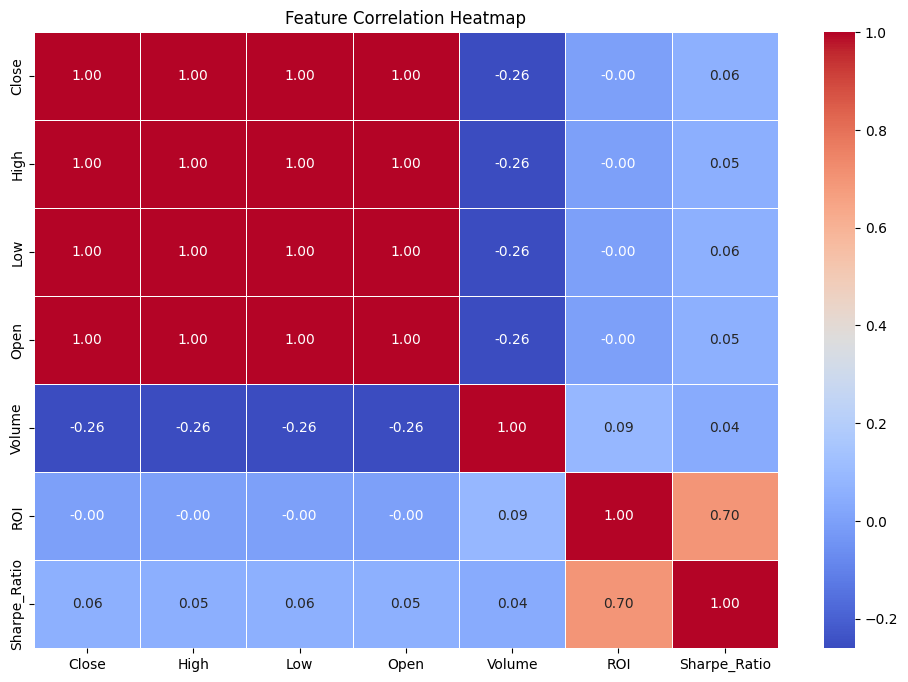

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load dataset with tqdm progress
tqdm.pandas(desc="Loading Data")
df = pd.read_csv("./data/final_stock_data.csv", parse_dates=["Date"])

# Fill missing values efficiently
df.fillna(method="ffill", inplace=True)
df.fillna(method="bfill", inplace=True)

# Encode Date as numerical feature (days since start)
df["Date"] = (df["Date"] - df["Date"].min()).dt.days

# Encode Stock as categorical feature
label_encoder = LabelEncoder()
df["Stock"] = label_encoder.fit_transform(df["Stock"].astype(str))

# Select features for modeling
features = ["Date", "Stock", "Close", "High", "Low", "Open", "Volume", "ROI", "Sharpe_Ratio"]
target = "Close"  # Using Close price as the target for prediction

# Normalize features with MinMaxScaler
scaler = MinMaxScaler()
df.loc[:, features] = scaler.fit_transform(df[features])

# Convert to NumPy arrays
X = df[features].values
y = df[target].values  # Target variable

# Split dataset (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

# Save processed dataset to CSV
df.to_csv("./data/processed_stock_data.csv", index=False)
print("✅ Processed dataset saved as 'processed_stock_data.csv'")

# Save NumPy arrays for model training & evaluation
np.save("./data/train_test/X_train.npy", X_train)
np.save("./data/train_test/X_test.npy", X_test)
np.save("./data/train_test/y_train.npy", y_train)
np.save("./data/train_test/y_test.npy", y_test)
print("✅ NumPy arrays saved for model training & evaluation")

# Compute correlation matrix
corr_matrix = df[["Close", "High", "Low", "Open", "Volume", "ROI", "Sharpe_Ratio"]].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


Episode 1/500 | Train Loss: 0.1100 | Test Loss: 0.0724
Episode 2/500 | Train Loss: 0.2998 | Test Loss: 0.0359
Episode 3/500 | Train Loss: 0.3153 | Test Loss: 0.0205
Episode 4/500 | Train Loss: 0.3133 | Test Loss: 0.0581
Episode 5/500 | Train Loss: 0.3116 | Test Loss: 0.0240
Episode 6/500 | Train Loss: 0.3084 | Test Loss: 0.0195
Episode 7/500 | Train Loss: 0.3112 | Test Loss: 0.0216
Episode 8/500 | Train Loss: 0.3119 | Test Loss: 0.0192
Episode 9/500 | Train Loss: 0.3185 | Test Loss: 0.0094
Episode 10/500 | Train Loss: 0.3101 | Test Loss: 0.0060
Episode 11/500 | Train Loss: 0.3319 | Test Loss: 0.0177
Episode 12/500 | Train Loss: 0.3182 | Test Loss: 0.0010
Episode 13/500 | Train Loss: 0.3350 | Test Loss: 0.0121
Episode 14/500 | Train Loss: 0.3392 | Test Loss: 0.0053
Episode 15/500 | Train Loss: 0.3096 | Test Loss: 0.0183
Episode 16/500 | Train Loss: 0.3266 | Test Loss: 0.0036
Episode 17/500 | Train Loss: 0.3411 | Test Loss: 0.0068
Episode 18/500 | Train Loss: 0.3330 | Test Loss: 0.0010
E

/tmp/ipykernel_4975/3213112517.py:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("tdqn_trading_model.pth"))


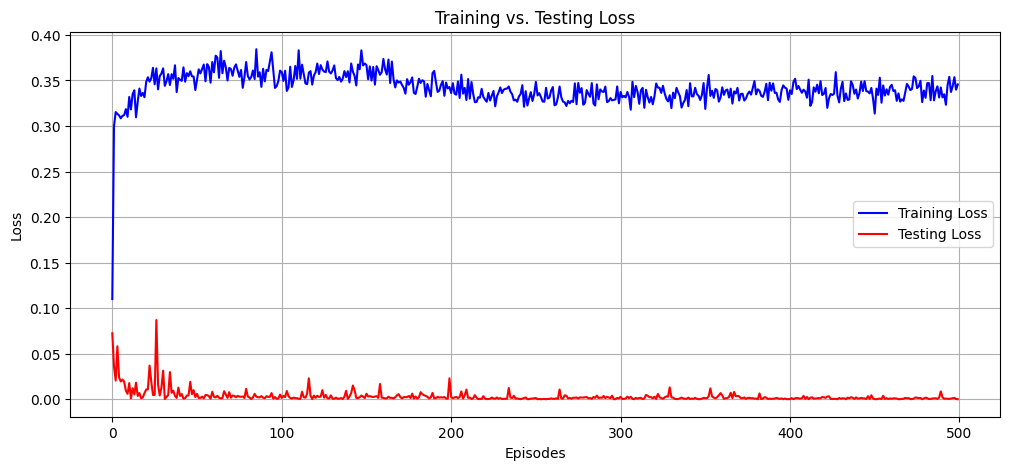

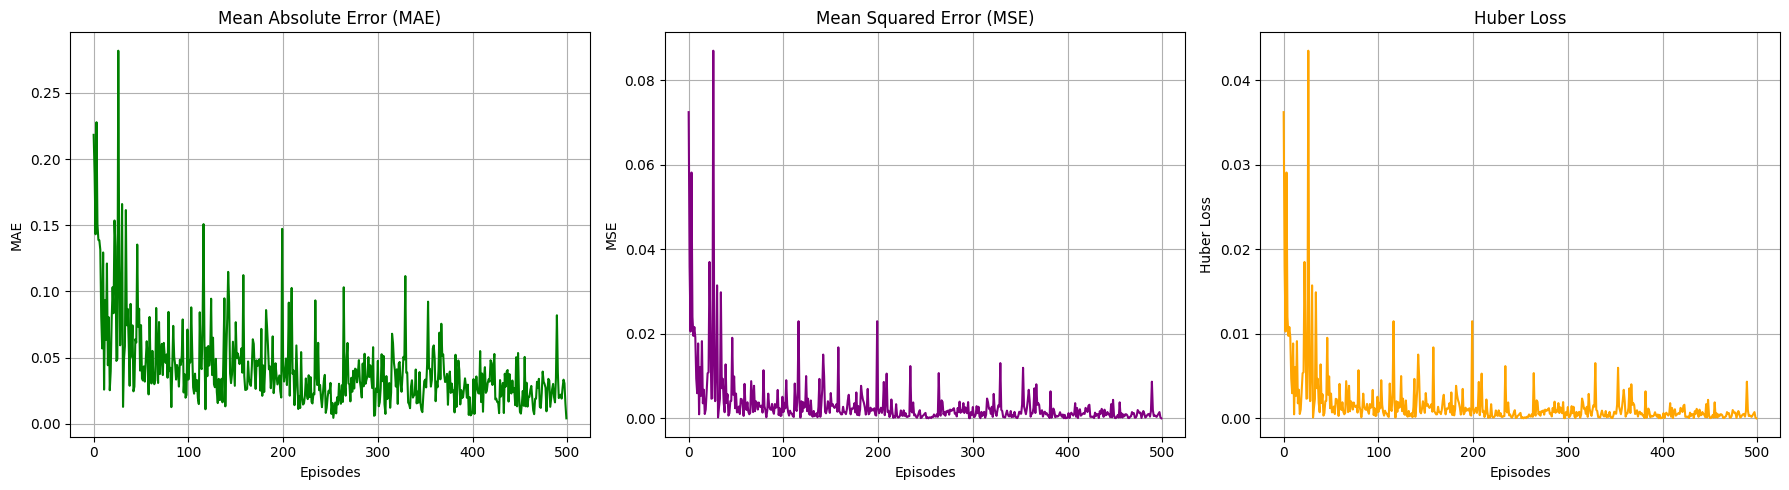

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

# Define TDQN Model
class TDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Hyperparameters
EPISODES = 500
GAMMA = 0.99
EPSILON = 1.0
EPSILON_DECAY = 0.995
MIN_EPSILON = 0.01
BATCH_SIZE = 32
LR = 0.001
TARGET_UPDATE = 10

# Assume 'X_train' and 'X_test' are prepared with stock features
input_dim = X_train.shape[1]
output_dim = 3  # Actions: Buy, Sell, Hold

# Initialize Model, Target Model & Optimizer
model = TDQN(input_dim, output_dim)
target_model = TDQN(input_dim, output_dim)
target_model.load_state_dict(model.state_dict())  # Sync initial weights
target_model.eval()

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

# Experience Replay Buffer
memory = deque(maxlen=10000)

# Metrics Tracking
train_losses = []
test_losses = []
mae_values = []
mse_values = []
huber_values = []

# Training Function
def train():
    global EPSILON
    for episode in range(EPISODES):
        state = torch.tensor(X_train[random.randint(0, len(X_train) - 1)], dtype=torch.float32)
        total_train_loss = 0

        for _ in range(50):  # 50 training steps per episode
            action = model(state).argmax().item() if random.random() > EPSILON else random.randint(0, 2)
            next_state = torch.tensor(X_train[random.randint(0, len(X_train) - 1)], dtype=torch.float32)
            reward = random.uniform(-1, 1)
            done = random.random() < 0.1
            memory.append((state, action, reward, next_state, done))

            if len(memory) < BATCH_SIZE:
                continue

            # Sample Mini-Batch
            batch = random.sample(memory, BATCH_SIZE)
            states, actions, rewards, next_states, dones = zip(*batch)
            states = torch.stack(states)
            actions = torch.tensor(actions, dtype=torch.long)
            rewards = torch.tensor(rewards, dtype=torch.float32)
            next_states = torch.stack(next_states)
            dones = torch.tensor(dones, dtype=torch.bool)

            # Q-Learning Targets
            q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze()
            next_q_values = target_model(next_states).max(1)[0].detach()
            target_q_values = rewards + GAMMA * next_q_values * ~dones

            # Compute Loss and Optimize
            loss = criterion(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)
        train_losses.append(total_train_loss / 50)

        # Validation Step
        with torch.no_grad():
            state = torch.tensor(X_test[random.randint(0, len(X_test) - 1)], dtype=torch.float32)
            q_values_test = model(state)
            target_q_values_test = target_model(state)
            test_loss = criterion(q_values_test, target_q_values_test).item()
            test_losses.append(test_loss)

            # Log Metrics
            mae_values.append(F.l1_loss(q_values_test, target_q_values_test).item())
            mse_values.append(F.mse_loss(q_values_test, target_q_values_test).item())
            huber_values.append(F.smooth_l1_loss(q_values_test, target_q_values_test).item())

        # Update Target Model
        if episode % TARGET_UPDATE == 0:
            target_model.load_state_dict(model.state_dict())

        print(f"Episode {episode+1}/{EPISODES} | Train Loss: {total_train_loss / 50:.4f} | Test Loss: {test_loss:.4f}")

# Train the model
train()

# Save Model
torch.save(model.state_dict(), "tdqn_trading_model.pth")
print("Model saved as 'tdqn_trading_model.pth'")

# Load Model (for inference)
loaded_model = TDQN(input_dim, output_dim)
loaded_model.load_state_dict(torch.load("tdqn_trading_model.pth"))
loaded_model.eval()

# --- 📊 Visualization ---

# Training vs. Testing Loss
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label="Training Loss", color="blue")
plt.plot(test_losses, label="Testing Loss", color="red")
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.title("Training vs. Testing Loss")
plt.legend()
plt.grid(True)
plt.show()

# Error Metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(mae_values, label="MAE", color="green")
axes[0].set_title("Mean Absolute Error (MAE)")
axes[0].set_xlabel("Episodes")
axes[0].set_ylabel("MAE")
axes[0].grid(True)

axes[1].plot(mse_values, label="MSE", color="purple")
axes[1].set_title("Mean Squared Error (MSE)")
axes[1].set_xlabel("Episodes")
axes[1].set_ylabel("MSE")
axes[1].grid(True)

axes[2].plot(huber_values, label="Huber Loss", color="orange")
axes[2].set_title("Huber Loss")
axes[2].set_xlabel("Episodes")
axes[2].set_ylabel("Huber Loss")        
axes[2].grid(True)

plt.tight_layout()
plt.show()
